In [12]:
import pyfredapi as pf
from rich.pretty import pprint
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
import os
api_key = os.environ.get('FRED_API_KEY')
print(api_key)

6d44e031497a740e7beb647aa485b62a


In [4]:
sc = pf.SeriesCollection(series_id=["MSPUS"]) # Median housing sale price
sc.add(series_id=["MORTGAGE30US"])  # Mortgage rates
sc.add(series_id=["MAPAINUSA672N"]) # Real mean personal income

sc.MSPUS.df.tail()

Requesting series MSPUS...
Requesting series MORTGAGE30US...
Requesting series MAPAINUSA672N...


,date,MSPUS
238,2022-07-01,468000.0
239,2022-10-01,479500.0
240,2023-01-01,429000.0
241,2023-04-01,418500.0
242,2023-07-01,431000.0


In [45]:
house_price_df = sc.MSPUS.df.sort_values(by='date',ascending=False)
mortgage_df = sc.MORTGAGE30US.df.sort_values(by='date',ascending=False)
income_df = sc.MAPAINUSA672N.df.sort_values(by='date',ascending=False)

display(house_price_df.head())
display(mortgage_df.head())
display(income_df.head())

,date,MSPUS
242,2023-07-01,431000.0
241,2023-04-01,418500.0
240,2023-01-01,429000.0
239,2022-10-01,479500.0
238,2022-07-01,468000.0


,date,MORTGAGE30US
2752,2023-12-28,6.61
2751,2023-12-21,6.67
2750,2023-12-14,6.95
2749,2023-12-07,7.03
2748,2023-11-30,7.22


,date,MAPAINUSA672N
48,2022-01-01,59430
47,2021-01-01,61620
46,2020-01-01,60910
45,2019-01-01,61650
44,2018-01-01,58270


In [52]:
house_price_df['date'] = pd.to_datetime(house_price_df['date'])
mortgage_df['date'] = pd.to_datetime(mortgage_df['date'])
income_df['date'] = pd.to_datetime(income_df['date'])

combined_df = pd.merge(mortgage_df, house_price_df, on='date', how='outer')
combined_df = pd.merge(combined_df, income_df, on='date', how='outer')

combined_df.sort_values(by='date', inplace=True)
combined_df.ffill(inplace=True)

combined_df = combined_df[combined_df['date'].isin(mortgage_df['date'])].sort_values(by='date',ascending=False)

combined_df.head(10)

,date,MORTGAGE30US,MSPUS,MAPAINUSA672N
0,2023-12-28,6.61,431000.0,59430.0
1,2023-12-21,6.67,431000.0,59430.0
2,2023-12-14,6.95,431000.0,59430.0
3,2023-12-07,7.03,431000.0,59430.0
4,2023-11-30,7.22,431000.0,59430.0
5,2023-11-22,7.29,431000.0,59430.0
6,2023-11-16,7.44,431000.0,59430.0
7,2023-11-09,7.50,431000.0,59430.0
8,2023-11-02,7.76,431000.0,59430.0
9,2023-10-26,7.79,431000.0,59430.0


In [57]:
combined_df['monthly_mortgage_rate'] = combined_df.apply(lambda row: (row['MORTGAGE30US']/100)/12, axis=1)
combined_df['monthly_income'] = combined_df.apply(lambda row: row['MAPAINUSA672N']/12, axis=1)
combined_df['median_monthly_payment'] = combined_df.apply(lambda row: (row['monthly_mortgage_rate'] * (row['MSPUS']*.9) * pow((1+row['monthly_mortgage_rate']),360))/(pow((1+row['monthly_mortgage_rate']),360)-1), axis=1)
combined_df['monthly_payment_to_income_ratio'] = combined_df.apply(lambda row: row['median_monthly_payment']/row['monthly_income'], axis=1)

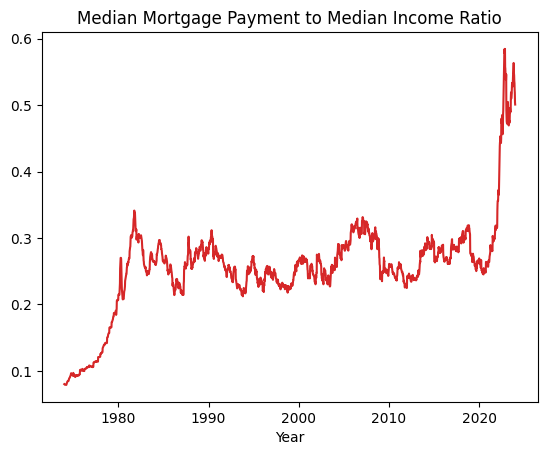

In [69]:
plt.figure()
plt.title('Median Mortgage Payment to Median Income Ratio')
plt.xlabel('Year')
plt.plot(combined_df.date, combined_df.monthly_payment_to_income_ratio, color='tab:red')
plt.show()

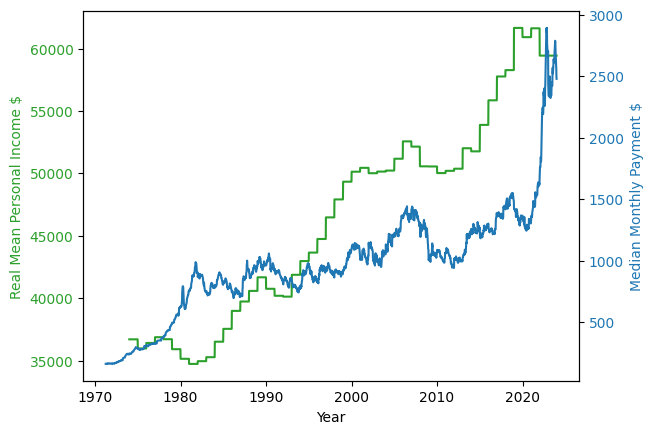

In [89]:
ax1 = plt.gca()
ax1.plot(combined_df.date, combined_df.MAPAINUSA672N, color='tab:green')  
ax1.set_xlabel('Year')
ax1.set_ylabel('Real Mean Personal Income $', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')


ax2 = ax1.twinx()
ax2.plot(combined_df.date, combined_df.median_monthly_payment, color='tab:blue', label='Median Monthly Payment')
ax2.set_ylabel('Median Monthly Payment $', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.show()